In [1]:
# doom project
# first i will start to import the modules for the project most importent vizdoom 
from vizdoom import * # and the vizdoom for the dom game envirnoment 
import random # her this for action sampling 
import time
import numpy as np 

In [2]:
# setup the game 
game = DoomGame()
game.load_config(r"C:\Users\HP\Desktop\doom_in\ViZDoom\scenarios\defend_the_center.cfg")# load the game sittings 
game.init()

In [3]:
actions = np.identity(3, dtype = np.uint) # the identity matrix of 3x3 matrix 
# so we made this identity matrix as in this game there is 3 avalibale botton (things the agent can do ) move left , move right , attack 
# so each one fo them will have its own array from the identity matrix [1,0,0] --> to move left etc....

In [4]:
# her we lopped throght the episodes 
episodes = 10 
for episode in range(episodes):
    game.new_episode() # her each loop we make new game 
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4)
        print("the reward", reward)
        time.sleep(0.02)
    print("result:", game.get_total_reward())
    time.sleep(2)


the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 1.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward 0.0
the reward

In [5]:
game.close()

In [2]:
# so for better use for machine learning we will convert it to gym envirnoment 
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete , Box
import cv2 # open cv , we can use it to gray scale our observation 

In [3]:
# start by creating vizdoom openai gym(i used gymnasium as it is the updates version of gym both nearly the same) envirnoment 
class vizdoomgym(Env):
    def __init__(self, render = False):
        super().__init__() # inheret from ore base Env class 
        # setup the game 
        self.game = DoomGame()
        self.game.load_config(r"C:\Users\HP\Desktop\doom_in\ViZDoom\scenarios\defend_the_center.cfg")
        
        # see if we want ro render the game or only let it process with out watching it 
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # her i Create the action space and observation space for the game 
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
    def step(self, action):
        actions = np.identity(3, dtype = np.uint)
        reward = self.game.make_action(actions[action],4)
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]  
            info = dict({"ammo": ammo})      
        else:
            state = np.zeros(self.observation_space.shape)
            info = dict({"ammo": 0})

        done = self.game.is_episode_finished()
        
        return state, reward,done,False, info 
    def close(self):
        self.game.close()
    def render():
        pass
    def grayscale(self,observation):
        gray = cv2.cvtColor(np.moveaxis(observation,0,-1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation = cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    def reset(self,seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        
        return self.grayscale(state), {}

        

In [37]:
env = vizdoomgym(render = True)


In [38]:
state = env.reset()

In [40]:
env.close()

In [14]:
# envirnoment chacker 
from stable_baselines3.common import env_checker # cheack if the envirnoment i made is valid or not 

In [25]:
env_checker.check_env(env) # we got valid envirnoment 

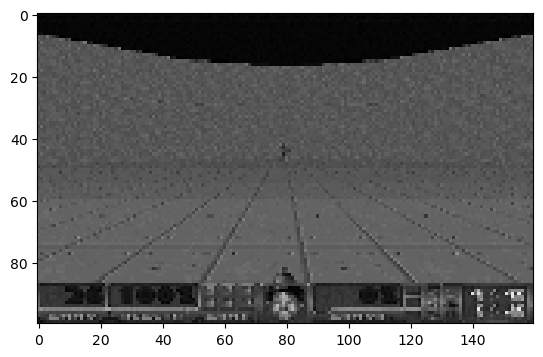

In [39]:
# view the game 
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [11]:
# now we will start to setup the calback 
# as if some thing happend while train we will have the best version of the model # and can even adjust with it more options 

In [4]:
import os 
from stable_baselines3.common.callbacks import BaseCallback # import callbacks from stable-baseline the library we will used for the model and 
# reinforcment learning things 

In [42]:
class callback(BaseCallback):
    def __init__(self,check_frq, save_path, verbose =1):
        super(callback, self).__init__(verbose)
        self.check_frq = check_frq
        self.save_path = save_path
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_frq == 0: # ensure to save the model every 10000 step 
            model_path = os.path.join(self.save_path, "best_model{}".format(self.n_calls))
            self.model.save(model_path)

        return True

In [43]:
check_dir = "./train/train_defend"
log_dir = "./logs/log_defend"

In [44]:
cb = callback(check_frq=10000 , save_path =check_dir) # calback instance 

In [5]:
# train our model 
# we will use the PPO algorithm from stable-baseline 
from stable_baselines3 import PPO

In [51]:
env = vizdoomgym() # take an instance from our envirnoment that will not be rendered while training 

In [ ]:
model = PPO('CnnPolicy', env , tensorboard_log=log_dir, verbose =1, learning_rate=0.0001, n_steps=4096,device='cuda')
# the n_step number is simply how many frames(steps) the agent going to take and store in the buffer before it go and run yhe actor and critic 

In [53]:
model.learn(total_timesteps=100000, callback=cb)
# it will give us like 2 matrices 
# first one the thimgs in it represent the information collected during envirnoment interaction 
# the second one represet some statistics from the training process  


Logging to ./logs/log_defend\PPO_1


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 80.2     |
|    ep_rew_mean     | 0.28     |
| time/              |          |
|    fps             | 19       |
|    iterations      | 1        |
|    time_elapsed    | 214      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 86.2        |
|    ep_rew_mean          | 0.537       |
| time/                   |             |
|    fps                  | 13          |
|    iterations           | 2           |
|    time_elapsed         | 627         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008079686 |
|    clip_fraction        | 0.0403      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0201329  |
|    learning_rate        | 0.

In [6]:
# test and check the model 
# in stable - baseline we have evaluatiing_policy that can evaluate our model 

from stable_baselines3.common.evaluation import evaluate_policy


In [8]:
model_100 = PPO.load(r"C:\Users\HP\Desktop\0e135d5a-5fda-4499-997b-1bfd5abaaa1b_FlaskChess.zip.a1b\train\train_defend\best_model100000.zip")


In [33]:
env = vizdoomgym(render = True)

In [34]:
mean_reward ,_ = evaluate_policy(model_100 , env , n_eval_episodes=2)

In [35]:
mean_reward

np.float64(18.5)

In [36]:
env.close()